# 01_summary_statistics.ipynb

In [4]:
import contextily as cx
import figure_utilities
import figure_and_table_constants
import constants
from stats_utilities import produce_summary_statistics
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
import os
import pandas as pd

# Store paths.
INPUT_DATA_UNRESTRICTED = "../../data/03_cleaned/unrestricted_monthly.parquet"
INPUT_DATA_RESTRICTED = "../../data/03_cleaned/crime_analysis_monthly.parquet"
INPUT_DATA_TRACTS = "../../data/02_intermediate/tracts.csv"
INPUT_DATA_BOSTON_TRACTS_SHAPEFILE = "../../data/01_raw/Census_2010_Tracts"

OUTPUT_TABLES = "../../output/summary_statistics/tables"
OUTPUT_FIGURES = "../../output/summary_statistics/figures"

# Read unrestricted dataset into memory.
df = pd.read_parquet(INPUT_DATA_RESTRICTED)

# Drop malformed addresses.
df = df.loc[~df['property_address_full'].str.contains("span, span span"), :]

# So we can use 'case_number' like a column
df = df.reset_index()
print(df['poor_share2010'].quantile(.75
                                    ))

0.38699785


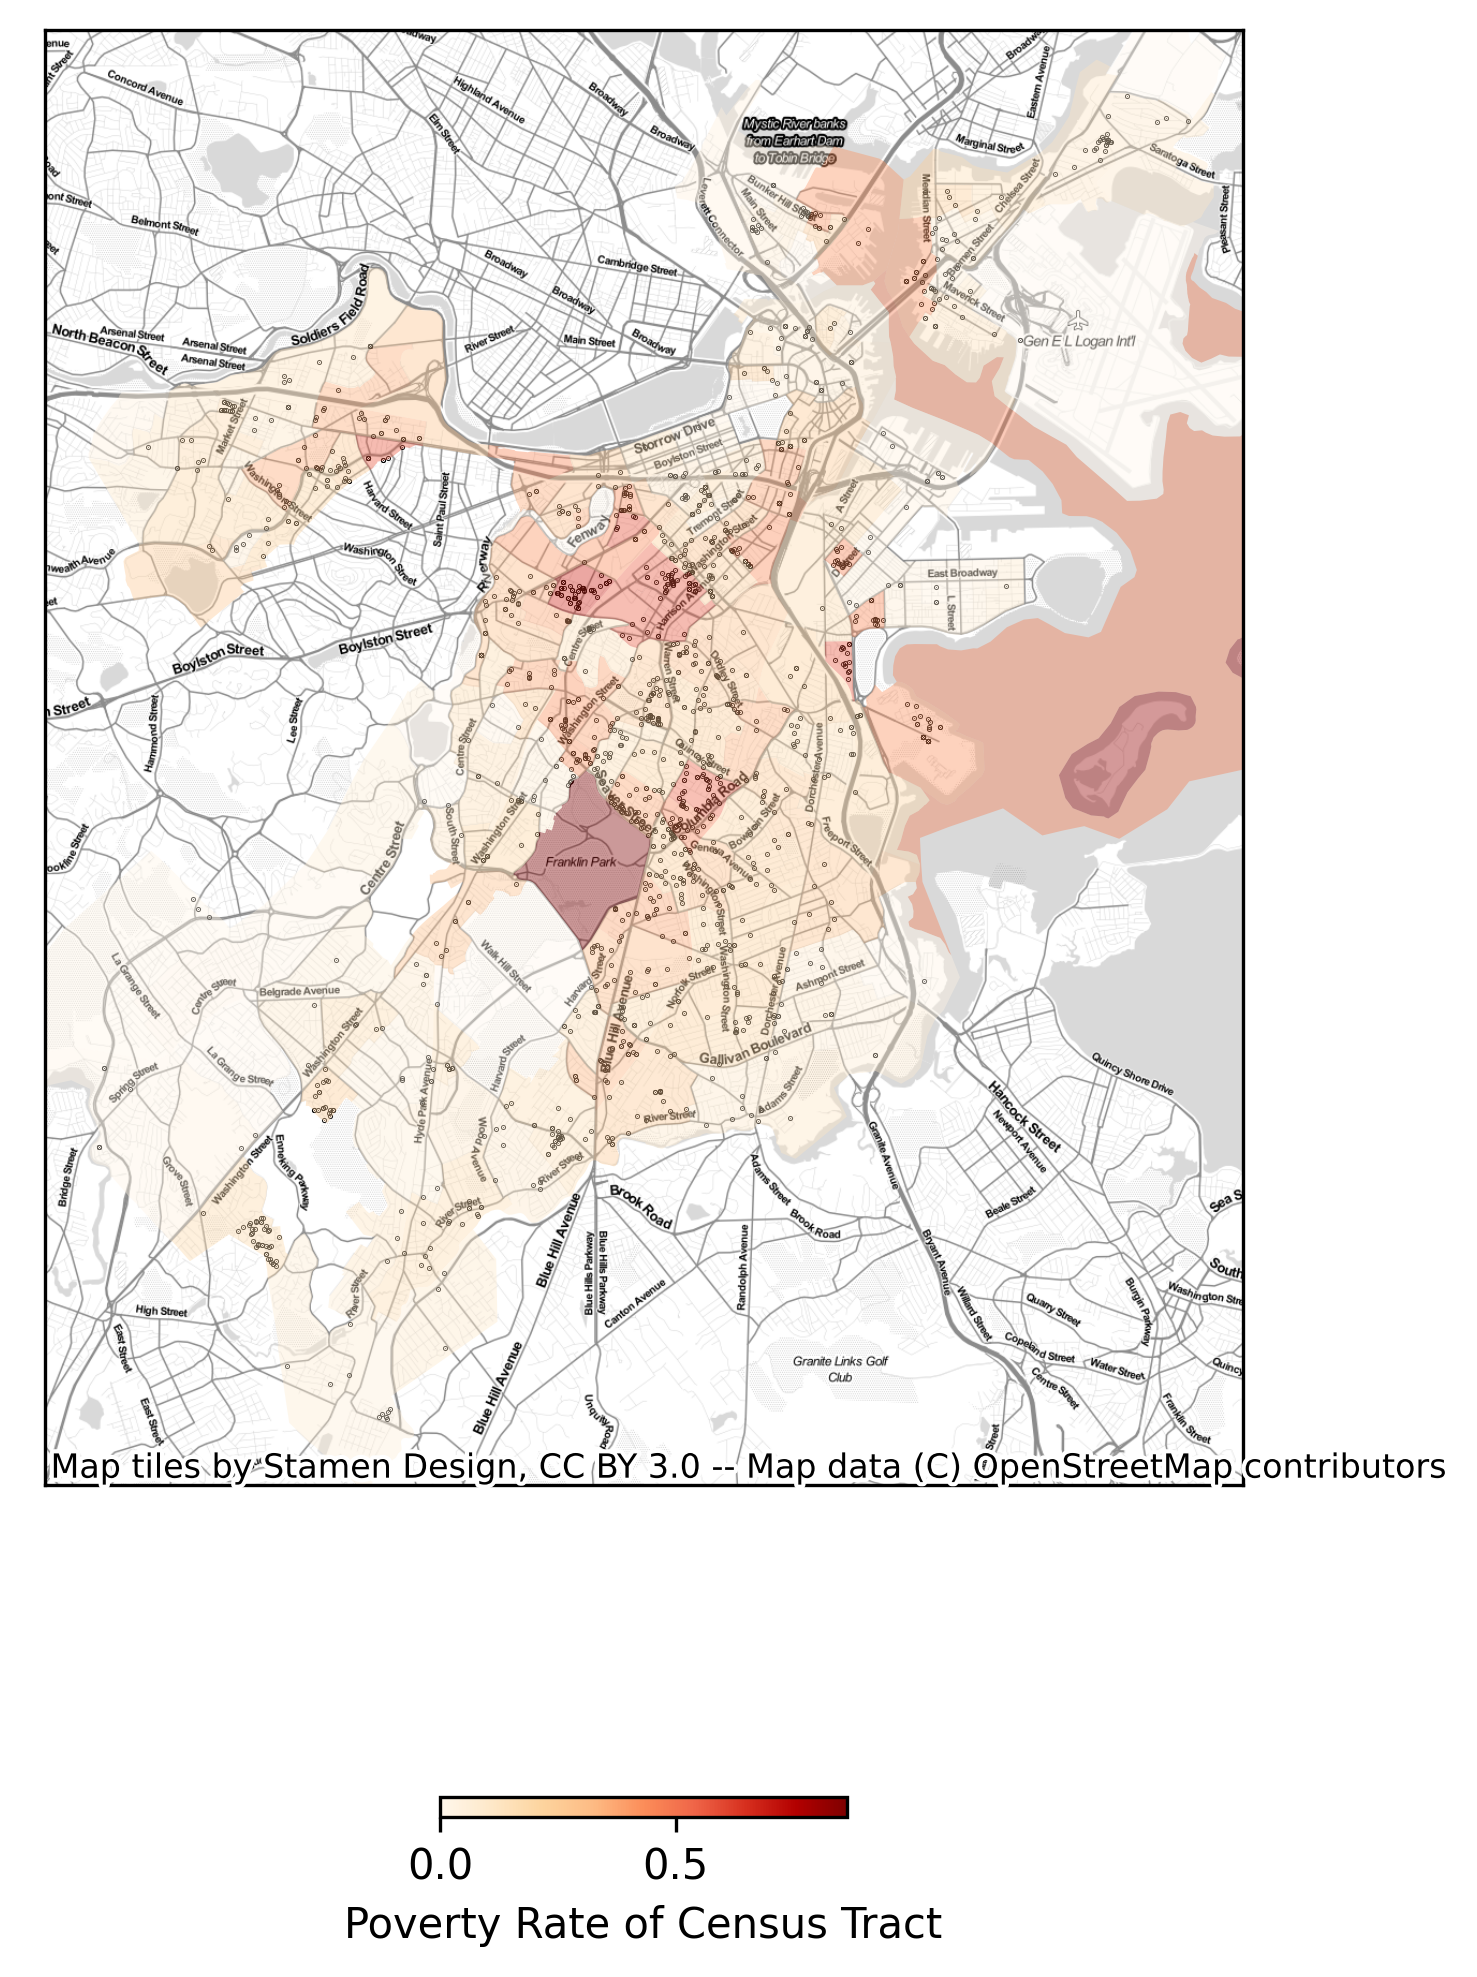

In [21]:
 # Plot evictions spatially.
unrestricted_gdf = gpd.GeoDataFrame(df,
                                    geometry=gpd.points_from_xy(df['Longitude'],
                                                                df['Latitude']))
unrestricted_gdf = unrestricted_gdf.set_crs("EPSG:4326")
unrestricted_gdf = unrestricted_gdf.to_crs("EPSG:3857")
fig, ax = plt.subplots(figsize=(7, 9))
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_xticks([])
unrestricted_gdf.plot(ax=ax,
                      color='black',
                      markersize=0.05)
cx.add_basemap(ax=ax, crs="EPSG:3857", source=cx.providers.Stamen.TonerLite)

# Color census tracts by poverty rate.
boston_tracts_gdf = gpd.read_file(INPUT_DATA_BOSTON_TRACTS_SHAPEFILE)[['GEOID10', 'geometry']].set_index('GEOID10')
boston_tracts_gdf.index = boston_tracts_gdf.index.astype(int)
tract_poverty_rates_df = pd.read_csv(INPUT_DATA_TRACTS, usecols=['tract_geoid', 'poor_share2010'], index_col='tract_geoid')

boston_tracts_gdf = pd.concat([boston_tracts_gdf, tract_poverty_rates_df], axis=1).dropna(subset=['geometry', 'poor_share2010'])
boston_tracts_gdf.plot(ax=ax, column=boston_tracts_gdf['poor_share2010'], cmap='OrRd', alpha=0.4, legend=True, legend_kwds={'label': "Poverty Rate of Census Tract",
                                                                                                               'orientation': "horizontal",
                                                                                                               'shrink': 0.25})


plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "evictions_map.png"))

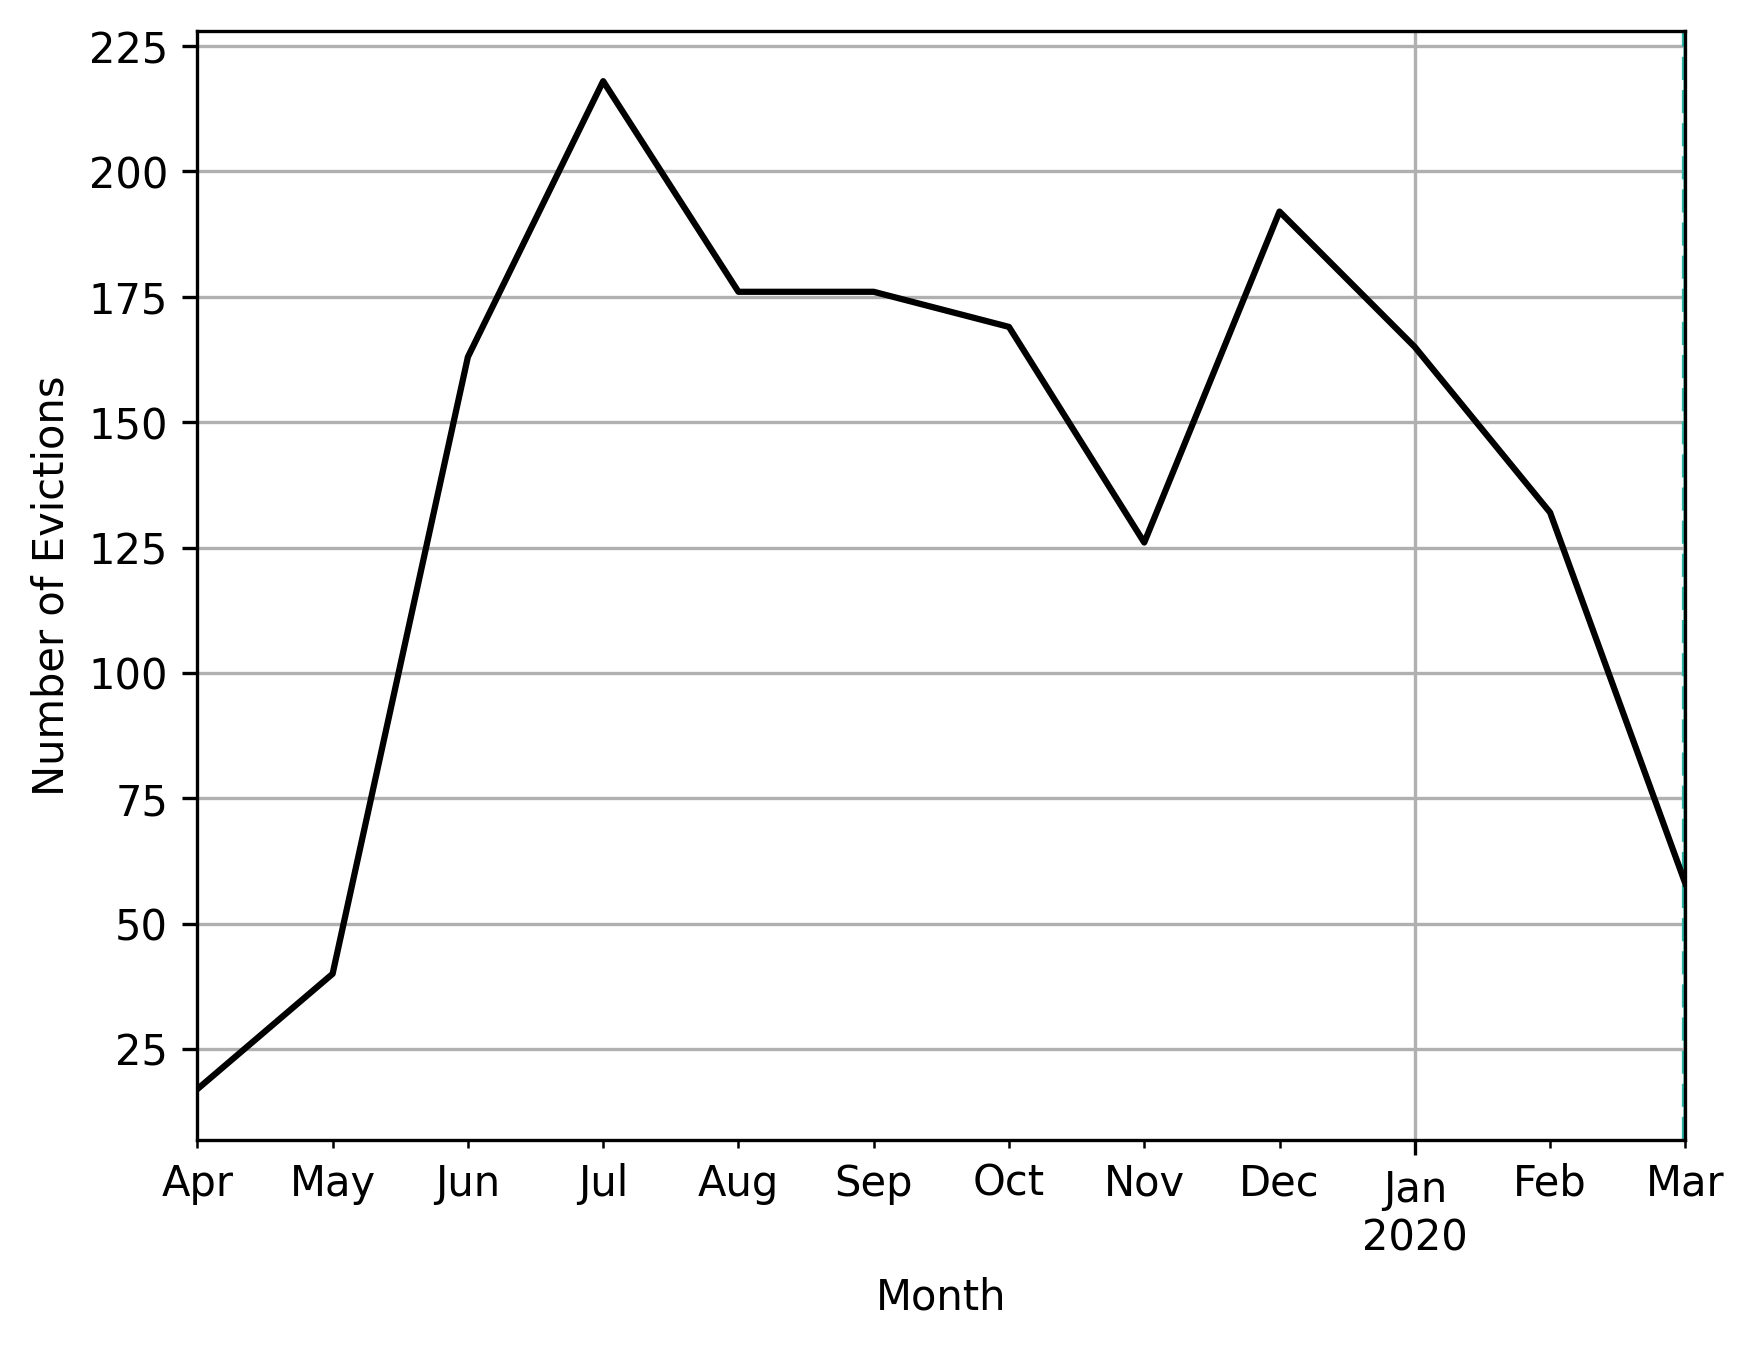

In [22]:
# Plot the number of eviction filings over time.
df.loc[:, 'last_day_of_file_month'] = (pd.to_datetime(df['file_date']) +
                                                    pd.tseries.offsets.MonthEnd(0))
filings_per_month = df.groupby('last_day_of_file_month')['case_number'].count()

# Plot eviction filing counts.
fig, ax = plt.subplots()
filings_per_month.plot(ax=ax, kind='line', color=figure_and_table_constants.Colors.SUMMARY_STATISTICS_COLOR,
                       zorder=100)
ax.set_ylabel("Number of Evictions")
ax.set_xlabel("Month")
ax.grid(True)

# Plot the beginning and end of the CARES act moratorium.
CARES_beginning = pd.Timestamp("2020-03-27")
CARES_end = pd.Timestamp("2020-08-23")
CARES_color = figure_and_table_constants.Colors.P1
figure_utilities.plot_labeled_vline(ax=ax, x=CARES_beginning, text='', color=CARES_color)
figure_utilities.plot_labeled_vline(ax=ax, x=CARES_end, text='', color=CARES_color)
ax.axvspan(CARES_beginning, CARES_end, color=CARES_color, alpha=0.5)

# Plot the beginning and end of the CDC moratorium.
CDC_beginning = pd.Timestamp("2020-09-04")
CDC_end = pd.Timestamp("2021-08-26")
CDC_color = figure_and_table_constants.Colors.P2
figure_utilities.plot_labeled_vline(ax=ax, x=CDC_beginning, text='', color=CDC_color)
figure_utilities.plot_labeled_vline(ax=ax, x=CDC_end, text='', color=CDC_color)
ax.axvspan(CDC_beginning, CDC_end, color=CDC_color, alpha=0.5)

# Plot the beginning and end of the MA state moratorium.
MA_beginning = pd.Timestamp("2020-04-20")
MA_end = pd.Timestamp("2020-10-17")
MA_color = figure_and_table_constants.Colors.P7
figure_utilities.plot_labeled_vline(ax=ax, x=MA_beginning, text='', color=MA_color)
figure_utilities.plot_labeled_vline(ax=ax, x=MA_end, text='', color=MA_color)
ax.axvspan(MA_beginning, MA_end, color=MA_color, alpha=0.5)

# Build legend.
# legend_elements = [Line2D([0], [0], color='black', label='Evictions per Month'),
#                    Patch(facecolor=CARES_color, edgecolor=CARES_color, label='CARES Act Eviction Moratorium',
#                          alpha=0.5, linestyle='--'),
#                    Patch(facecolor=MA_color, edgecolor=MA_color, label='MA Bill H.4647', alpha=0.5,
#                          linestyle='--'),
#                    Patch(facecolor=CDC_color, edgecolor=CDC_color, label='CDC Eviction Moratorium', alpha=0.5,
#                          linestyle='--')]
# ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "filings_over_time.png"))

In [23]:
# Produce summary statistics for unrestricted sample.
treatment_date_variable = 'latest_docket_date'
outcomes_of_interest = ['group_0_crimes_500m']
summary_statistics_unrestricted, variable_display_names_dict  = produce_summary_statistics(df,
                                                                                           treatment_date_variable=treatment_date_variable)

# Rename columns.
summary_statistics_unrestricted.index = summary_statistics_unrestricted.index.set_names(["Panel", "Variable"])
column_display_names_dict = {'mean': "Mean", 'std': "S.D.", 'count': "N", '50%': 'Median'}

summary_statistics_unrestricted = summary_statistics_unrestricted.sort_values(['Panel', 'Variable'])
# Keep only outcomes of interest
outcomes = constants.Variables.outcomes.copy()
for outcome in outcomes:
    if outcome not in outcomes_of_interest:
        if f"pre_treatment_change_in_{outcome}" in summary_statistics_unrestricted.index.get_level_values(1):
            summary_statistics_unrestricted = summary_statistics_unrestricted.drop(f"pre_treatment_change_in_{outcome}", level=1, axis=0)
        if f"total_twenty_seventeen_{outcome}" in summary_statistics_unrestricted.index.get_level_values(1):
            summary_statistics_unrestricted = summary_statistics_unrestricted.drop(f"total_twenty_seventeen_{outcome}", level=1, axis=0)

# Drop Panel F.
summary_statistics_unrestricted = summary_statistics_unrestricted.drop("Panel F: Post-treatment Outcomes", level=0, axis=0)

# Drop median column.
summary_statistics_unrestricted = summary_statistics_unrestricted.drop(columns='50%')


# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "summary_statistics.tex")
latex = (summary_statistics_unrestricted
         .rename(index=variable_display_names_dict)
         .rename(columns=column_display_names_dict)
         .style
         .format(formatter={
                            'Mean': "{:,.2f}",
                            'Median': "{:,.2f}",
                            'S.D.': "{:,.2f}",
                            'N': "{:,.0f}"})
         .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
         .to_latex(None,
                   column_format="llcccc",
                   hrules=True,
                   clines="skip-last;data")).replace("{*}", "{4cm}")
with open(filename, 'w') as file:
    file.write(latex)
summary_statistics_unrestricted

mean  \
Panel                                            Variable                                                    
Panel A: Pre-treatment Outcomes                  pre_treatment_change_in_group_0_crimes_500m   -152.000000   
                                                 total_twenty_seventeen_group_0_crimes_500m    1162.734069   
Panel B: Census Tract Characteristics            frac_coll_plus2010                               0.314230   
                                                 job_density_2013                             16511.952590   
                                                 med_hhinc2016                                46399.337623   
                                                 poor_share2010                                   0.288963   
                                                 popdensity2010                               23373.287706   
Panel C: Case Initiation                         for_cause                                        0.113971   
                                                 no_cause                                         0.042892   
                                                 non_payment                                      0.761029   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                         0.032475   
                                                 hasAttyP                                         0.906250   
                                                 isEntityD                                        0.024510   
                                                 isEntityP                                        0.843137   
Panel E: Case Resolution                         case_duration                                   19.821196   
                                                 defaulted                                        0.480392   
                                                 dismissed                                        0.414216   
                                                 heard                                            0.047794   
                                                 issued                                           0.303922   
                                                 judgment                                      1456.983762   
                                                 levied                                           0.058211   
                                                 mediated                                         0.000000   
                                                 requested                                        0.022672   
                                                 unknown_execution                                0.000000   

                                                                                                       std  \
Panel                                            Variable                                                    
Panel A: Pre-treatment Outcomes                  pre_treatment_change_in_group_0_crimes_500m    217.380078   
                                                 total_twenty_seventeen_group_0_crimes_500m     714.550852   
Panel B: Census Tract Characteristics            frac_coll_plus2010                               0.216728   
                                                 job_density_2013                             43184.205518   
                                                 med_hhinc2016                                25059.819469   
                                                 poor_share2010                                   0.153080   
                                                 popdensity2010                               14260.043071   
Panel C: Case Initiation                         for_cause                                        0.317873   
                                                 no_cause                                         0.202676   
                               

In [24]:
treatment_timings = (df
                     .groupby(['latest_docket_month', 'judgment_for_plaintiff'])['case_number']
                     .count()
                     .reset_index()
                     .fillna(0))
treatment_timings = treatment_timings.pivot(index='latest_docket_month', columns='judgment_for_plaintiff').fillna(0)
treatment_timings.columns = ["Cases Won By Defendant", "Cases Won By Plaintiff"]
portion_of_all_cases = (treatment_timings['Cases Won By Plaintiff'] + treatment_timings['Cases Won By Defendant']) / len(df)
treatment_timings = pd.concat([treatment_timings, portion_of_all_cases.rename('Portion of All Cases')], axis=1)
sum_across_filing_date = pd.DataFrame(treatment_timings.sum(axis=0)).T
sum_across_filing_date.index = ["All Months"]
treatment_timings = pd.concat([sum_across_filing_date, treatment_timings], axis=0)
treatment_timings.index = treatment_timings.index.rename("Last Docket Date")

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "treatment_timings.tex")
treatment_timings.style.format(formatter={'Cases Won By Plaintiff': '{:,.0f}',
                                          'Cases Won By Defendant': '{:,.0f}',
                                           'Portion of All Cases': '{:0.2f}'}).to_latex(filename, column_format="lccc", hrules=True)
treatment_timings

,Cases Won By Defendant,Cases Won By Plaintiff,Portion of All Cases
Last Docket Date,,,
All Months,677.0,955.0,1.000000
2019-04,1.0,5.0,0.003676
2019-05,1.0,7.0,0.004902
2019-06,50.0,24.0,0.045343
2019-07,63.0,47.0,0.067402
2019-08,64.0,110.0,0.106618
2019-09,69.0,101.0,0.104167
2019-10,82.0,98.0,0.110294
2019-11,56.0,76.0,0.080882


In [27]:
# Calculate percent of cases which are in high poverty neighborhoods.
df = df.loc[df['judgment_for_plaintiff'] == 1, :]
original_N = len(df)
cases_in_poor_tracts = len(df.loc[df['poor_share2010'] > 0.20, :])
cases_in_poor_tracts / original_N


0.6408376963350786